# Ocean Climate Project

In this notebook, we will be looking at ocean temperature data from the Comfort Cove site.

1. [Removing Duplicates](#Removing-Duplicates)
2. [Extracting File Headers](#Extracting-File-Headers)
3. [Converting to netCDF files](#Converting-to-netCDF-File)
4. [Plotting](#Plotting)
5. [Climatology](#Climatology)
6. [Upwells](#Upwells)


Giulia Bronzi  
June - August 2020

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import xarray
import copy
import seaborn as sns
from datetime import date
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta

In [2]:
# Generates list of file names
infiles = 'comfortcove.list'
os.system('ls ~/Desktop/ComfortCove/*.rpf > ' + infiles)
filelist = np.genfromtxt(infiles, dtype=str)
filelist = np.reshape(filelist, filelist.size) 

In [3]:
#creates an array of data frames 
#each data frame has datetime index and column of temperatures
dfs = []
for fname in filelist: 
    try: 
        df = pd.read_csv(fname, sep='\s+',  parse_dates={'datetime': [0, 1]}, header=16)
        df = df.set_index('datetime')
        df.columns = ['temperature']
        df = df.replace(9999.99, np.NaN)
        dfs.append(df)
    except:
        #empty files are ignored
        print (fname + ' is empty [ignore file]')
        continue

/Users/giuliabronzi/Desktop/ComfortCove/MTR_85_1989_05_16_trimmed.rpf is empty [ignore file]


This is an example of one of the dataframes in the array 'df', created above. Each row represents one hour from a day and there is one data frame for each file in the 'filelist'. 

In [4]:
print(dfs[0])

                     temperature
datetime                        
1993-12-02 17:00:00         2.30
1993-12-02 18:00:00         2.25
1993-12-02 19:00:00         2.25
1993-12-02 20:00:00         2.25
1993-12-02 21:00:00         2.20
...                          ...
1994-05-05 08:00:00        -0.10
1994-05-05 09:00:00        -0.05
1994-05-05 10:00:00        -0.05
1994-05-05 11:00:00         1.25
1994-05-05 12:00:00         0.55

[3692 rows x 1 columns]


In [5]:
#concatenates all the data from each data frame in dfs
df_all = pd.concat(dfs, axis=0)

#we end up with a sorted dataframe, with all the data in a single dataframe 
df_all = df_all.sort_index()

In [6]:
#will be used in a later section
dfCopy = copy.deepcopy(df_all)

## Removing Duplicates

In some cases, there are two different temperature readings from a specific timestamp. For these duplicates, we use the resample method to find the maximum and minimum temperature, which we then use to calculate the mean temperature of that hour. 

For example, below we can see that there are four rows with the timestamp '1995-08-05 14:00' and two different recorded temperatures. So, we would find the max temp (8.25) and the min temp (7.45), and take the average. After we run all of our code, we should see that for this specific timestamp, we have a new temperature of 7.85. 

In [7]:
df_all[100000:100010]

,temperature
datetime,
1995-08-05 14:00:00,8.25
1995-08-05 14:00:00,7.45
1995-08-05 14:00:00,7.45
1995-08-05 14:00:00,8.25
1995-08-05 15:00:00,7.05
1995-08-05 15:00:00,6.85
1995-08-05 15:00:00,6.85
1995-08-05 15:00:00,7.05
1995-08-05 16:00:00,6.90


In [8]:
#sets temperature to the average (if not a duplicate, it doesn't affect temp)
df_all['temperature'] = ((df_all.temperature.resample('H').max() + df_all.temperature.resample('H').min())/2)  

In [9]:
df_all.index.shape

(357228,)

In [10]:
#makes datetime a column again so its easier to delete duplicates
df_all = df_all.reset_index()

In [11]:
#drops datetime duplicates
df_all = df_all.drop_duplicates(subset='datetime')

In [12]:
#resets index to datetime
df_all = df_all.set_index('datetime')

In [13]:
df_all[54274:54280]

,temperature
datetime,
1995-08-05 13:00:00,9.300
1995-08-05 14:00:00,7.850
1995-08-05 15:00:00,6.950
1995-08-05 16:00:00,6.950
1995-08-05 17:00:00,7.575
1995-08-05 18:00:00,7.175


Here we can see that the duplicates have been removed and the temperature for '1995-08-05 14:00' is 7.85 degrees, as stated above.

In [14]:
df_all.index.shape

(172113,)

Initially, df_all had 357228 rows, but after we delete the duplicates we are left with 172113.

### Why we chose to remove duplicates this way:

When we remove duplicates, we take the average observed temperature for that timestamp. We chose to do it this way because 95.4% of the timestamps have a temperature difference less than one. Of those, ~40% have a temperature difference of zero. Thus, we felt it would not drastically alter our results by taking the average temperature. While there are some timestamps with a larger difference, it is a very small proportion of the data. We will look at the temperature differences in more detail below, with the help of the resample method and histograms. 

The dataframe we use in this section, 'dfCopy', is the same as 'df_all', except, instead of taking the average temperature for duplicates, we find the temperature difference between duplicates. Because of this, the values in the temperature column for dfCopy are not the same as the values in df_all, but, we will only be looking at the timestamps and 'diff' column. We then delete the duplicates and are left with a dataframe of the same size as df_all. 

In [15]:
#resamples per hour and finds the difference between the max and min for each timestamp
dfCopy['diff'] = (dfCopy.temperature.resample('H').max() - dfCopy.temperature.resample('H').min()) 

In [16]:
#deletes duplicates the same as before
dfCopy = dfCopy.reset_index()
dfCopy = dfCopy.drop_duplicates(subset='datetime')
dfCopy = dfCopy.set_index('datetime')

**Note**: If the timestamp does not have a duplicate, the max and min will be the same, and therefore the difference will be zero.   

So, in cases where the difference is zero, the two possible scenarios are:
1. The timestamp does not have a duplicate.
2. The timestamp has a duplicate, but the recorded temperature is the same for all duplicates.

In [17]:
#all rows where the difference is zero
dfCopy[dfCopy['diff'] == 0]

,temperature,diff
datetime,,
1989-05-16 03:00:00,5.20,0.0
1989-05-16 04:00:00,4.50,0.0
1989-05-16 05:00:00,3.80,0.0
1989-05-16 06:00:00,3.40,0.0
1989-05-16 07:00:00,3.10,0.0
...,...,...
2019-10-23 14:00:00,8.68,0.0
2019-10-23 15:00:00,8.62,0.0
2019-10-23 16:00:00,8.62,0.0


Here we can see that 58% (101106/172113) of all the data (after duplicates have been deleted) have a difference of zero.  

Below, we can see a histogram that helps show the distribution of duplicate differences. The majority fall between zero and one degrees, but there are 1884 rows (~1%) that have a difference greater than 2 degrees. 

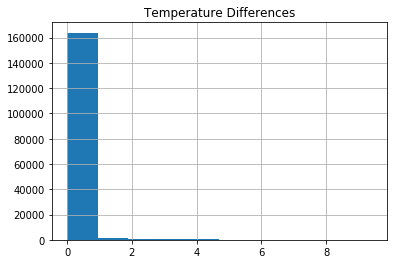

In [18]:
dfCopy.hist(column = "diff")
plt.title("Temperature Differences")
plt.show()

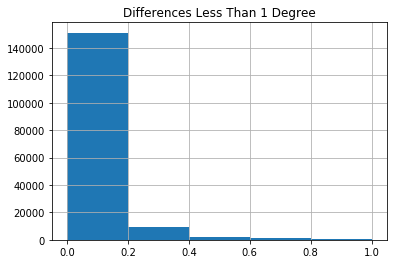

In [19]:
dfCopy.hist(column = "diff", bins= [0,0.2,0.4,0.6,0.8,1])
plt.title("Differences Less Than 1 Degree")
plt.show()

If we zoom into the differences that are less than 1, we can see that the majority fall between 0 and 0.2 degrees. 

Again, we are looking at all the rows (even ones that don't have duplicates) so a proportion of the results in this interval are due to the zeroes we get from the non-duplicates. But, even if we were to ignore these non-duplicates, we can the see that the differences tend towards smaller numbers. 

When we zoom into the differences greater than 1, we can also see that the results are skewed towards smaller differences. The largest difference in this dataset is 9.4 degrees, but there are only 7 rows (0.004%) where the temperature difference is greater than 9.

**Note**: The upper bound on the histogram below is ~1,000 while the upper bound on the above histogram is ~150,000.

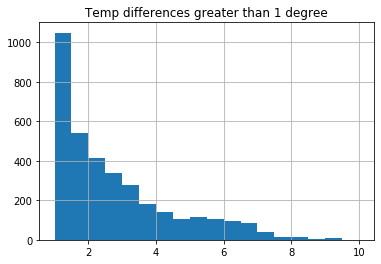

In [20]:
dfCopy.hist(column = "diff", bins= [1,1.5,2,2.5,3,3.5,4,4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5,9,9.5,10])
plt.title("Temp differences greater than 1 degree")
plt.show()

In conclusion, we decided to average the temperature for duplicated timestamps because most of the timestamps have a difference below one degree celcius. While there are some duplicates with a larger difference, they only account for a very small proportion. 

We will continue to look into why some timestamps have a much larger duplicate difference than other timestamps in the future. 

## Extracting File Headers

Each file has a header with pertinent information to the file. In total, there are 14 different header components, they can be seen below.

In [21]:
dfsHeader = [] 

#creates an array of dataframes, one df for each file 
#each dataframe holds the header info
for fname in filelist:
    dfH = pd.read_csv(fname, nrows = 14)
    headerValue = dfH["HEADER"].str.split("=", expand = True)
    dfH["Title"] = headerValue[0] #title --> header component, ex: site_name
    dfH["Value"] = headerValue[1] #value --> header value, ex: Comfort Cove
    dfH = dfH[['Title',"Value"]]
    dfsHeader.append(dfH)

Here we can see the header information for the first file in the Comfort Cove site folder.

In [22]:
dfsHeader[:1] #first header in the array

[                   Title                   Value
 0                STATION                     118
 1              SITE_NAME                    null
 2             START_DATE              1993-12-02
 3             START_TIME             16:00:00.00
 4               END_DATE              1994-05-05
 5               END_TIME             12:00:00.00
 6               LATITUDE                   49.41
 7              LONGITUDE                   54.83
 8              INST_TYPE             SEAMONUTR-B
 9          SERIAL_NUMBER                  007819
 10           WATER_DEPTH                    9.00
 11            INST_DEPTH                    9.00
 12     SAMPLING_INTERVAL               3600.0000
 13             FILE_NAME  MTR_100_1993_12_02.rpf]

In [23]:
#fourteen arrays, one for each header component, will be used to make a dataframe
station = []
siteName = []
startDate = []
startTime = []
endDate = []
endTime = []
latitude = []
longitude = []
instType = []
serialNumber = []
waterDepth = []
instDepth = []
samplingInterval = []
fileName = []

count = 0

#for each file, extracts the header value from the correct index
#adds each value to correlated array
for file in dfsHeader:
    station.append(dfsHeader[count]["Value"][0])
    siteName.append(dfsHeader[count]["Value"][1])
    startDate.append(dfsHeader[count]["Value"][2])
    startTime.append(dfsHeader[count]["Value"][3])
    endDate.append(dfsHeader[count]["Value"][4])
    endTime.append(dfsHeader[count]["Value"][5])
    latitude.append(dfsHeader[count]["Value"][6])
    longitude.append(dfsHeader[count]["Value"][7])
    instType.append(dfsHeader[count]["Value"][8])
    serialNumber.append(dfsHeader[count]["Value"][9])
    waterDepth.append(dfsHeader[count]["Value"][10])
    instDepth.append(dfsHeader[count]["Value"][11])
    samplingInterval.append(dfsHeader[count]["Value"][12])
    fileName.append(dfsHeader[count]["Value"][13])
    count += 1

In [24]:
#creates new dataframe based on the arrays created above
headers = {'Station': station,
           'SiteName': siteName,
           'StartDate': startDate,
           'StartTime': startTime,
           'EndDate': endDate,
           'EndTime': endTime,
           'Latitude': latitude,
           'Longitude': longitude,
           'InstType': instType,
           'SerialNumber': serialNumber,
           'WaterDepth': waterDepth,
           'InstDepth': instDepth,
           'SamplingInterval': samplingInterval,
           'FileName': fileName}

headersdf = pd.DataFrame(headers, columns = ['Station', 'SiteName', 'StartDate', 'StartTime', 'EndDate', 
                                             'EndTime','Latitude', 'Longitude',  'InstType', 'SerialNumber',
                                             'WaterDepth','InstDepth', 'SamplingInterval', 'FileName'])

In [25]:
#sorts by start date and end date
headersdf = headersdf.sort_values(by=['StartDate', 'EndDate'])
headersdf = headersdf.reset_index(drop = True)

In [26]:
#dataframe where each column is a component of the header
#each row is an individual file
headersdf

,Station,SiteName,StartDate,StartTime,EndDate,EndTime,Latitude,Longitude,InstType,SerialNumber,WaterDepth,InstDepth,SamplingInterval,FileName
0,118,COMFORT COVE,1989-05-16,02:00:00,1989-09-26,14:00:00,49.41,54.83,null,3264,9,null,null,MTR_30_1989_05_16.rpf
1,118,null,1989-05-16,02:00:00.00,1990-04-19,12:00:00.00,49.41,54.83,SEAMONUTR-B,003264,9.00,9.00,3600.0000,MTR_85_1989_05_16.rpf
2,118,COMFORT COVE,1989-09-26,13:00:00,1989-11-25,14:00:00,49.41,54.83,null,4361,9,null,null,MTR_31_1989_09_26.rpf
3,118,null,1989-09-26,13:00:00.00,1989-11-25,14:00:00.00,49.41,54.83,SEAMONUTR-B,004361,9.00,9.00,3600.0000,MTR_86_1989_09_26.rpf
4,118,COMFORT COVE,1989-11-25,15:00:00,1990-04-19,12:00:00,49.41,54.83,null,003264,09,null,null,MTR_32_1989_11_25.rpf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,null,Comfort Cove,2015-05-20,13:00:00,2015-10-29,13:00:00,null,null,Minilog-II-T,356307,null,null,01:00:00,MTR_80_2015_05_20.rpf
110,null,Comfort Cove,2016-05-22,18:00:00,2016-11-26,16:00:00,null,null,Minilog-II-T,355659,null,null,01:00:00,MTR_79_2016_05_22.rpf
111,null,Comfort Cove,2017-06-08,12:00:00,2017-11-27,19:00:00,null,null,Minilog-II-T,351103,null,null,01:00:00,MTR_75_2017_06_08.rpf
112,null,Comfort Cove,2018-05-21,18:39:38,2018-11-28,15:39:38,null,null,Minilog-II-T,354547,null,null,01:00:00,MTR_77_2018_05_21.rpf


One thing the header information is useful for is for verifying all the files in the folder are in the right place and that there are no values that shouldn't be there. Below, we can see that the site names for all the files are related to Comfort Cove.

In [27]:
#checking that the values are valid
headersdf['SiteName'].unique()

array(['COMFORT COVE', 'null', 'COMFORT COVE NOTRE DAME BAY',
       'Comfort Cove', 'Comfort Cove Sept', '', 'Comfort Cove -'],
      dtype=object)

## Converting to netCDF File 

In this section, we take the header information extracted above, and create a dataset that we then convert to a netCDF file. 

For the netCDF file, the dimension is based on the datetime index and the data variable is based on the temperature column. The attributes for the file are the components found in the header. 

In [28]:
#converting dataframe to dataset
xr = xarray.Dataset.from_dataframe(df_all)

#attribute values
station = str(headersdf['Station'].unique())
siteName = str(headersdf['SiteName'].unique())
start = str((headersdf['StartDate'] + ' ' + headersdf['StartTime']).values)
end = str((headersdf['EndDate'] + ' ' + headersdf['EndTime']).values)
latitude = str(headersdf['Latitude'].unique())
longitude = str(headersdf['Longitude'].unique())
instType = str(headersdf['InstType'].unique())
serialNumber = str(headersdf['SerialNumber'].unique())
waterDepth = str(headersdf['WaterDepth'].unique())
instDepth = str(headersdf['InstDepth'].unique())
samplingInterval = str(headersdf['SamplingInterval'].unique())
fileName = str(headersdf['FileName'].unique())


#sets the attributes
xr.attrs={'Station': station, 'SiteName': siteName, 'Start': start,'End': end,'Latitude': latitude,
          'Longitude': longitude, 'InstType': instType,'SerialNumber': serialNumber, 
          'WaterDepth': waterDepth,'InstDepth': instDepth,'SamplingInterval': samplingInterval,'FileName': fileName }

In [29]:
xr['temperature'].attrs={'units':'Celcius'}

In [30]:
xr

<xarray.Dataset>
Dimensions:      (datetime: 172113)
Coordinates:
  * datetime     (datetime) datetime64[ns] 1989-05-16T03:00:00 ... 2019-10-23T18:00:00
Data variables:
    temperature  (datetime) float64 5.2 4.5 3.8 3.4 3.1 ... 8.62 8.62 8.67 8.66
Attributes:
    Station:           ['118' 'null']
    SiteName:          ['COMFORT COVE' 'null' 'COMFORT COVE NOTRE DAME BAY' '...
    Start:             ['1989-05-16 02:00:00' '1989-05-16 02:00:00.00' '1989-...
    End:               ['1989-09-26 14:00:00' '1990-04-19 12:00:00.00' '1989-...
    Latitude:          ['49.41' 'null']
    Longitude:         ['54.83' 'null']
    InstType:          ['null' 'SEAMONUTR-B' 'Hugrun' 'SEAMONUTR-A' 'Minilog'...
    SerialNumber:      ['3264' '003264' '4361' '004361' '005456' '003261' '00...
    WaterDepth:        ['9' '9.00' '09' '10' '10.00' '009' 'null' '010']
    InstDepth:         ['null' '9.00' '10.00' '009' '010']
    SamplingInterval:  ['null' '3600.0000' '060' '01:00:00']
    FileName:          ['MTR_30_1989_05_16.rpf' 'MTR_85_1989_05_16.rpf' 'MTR_...

In [31]:
print(xr)

<xarray.Dataset>
Dimensions:      (datetime: 172113)
Coordinates:
  * datetime     (datetime) datetime64[ns] 1989-05-16T03:00:00 ... 2019-10-23T18:00:00
Data variables:
    temperature  (datetime) float64 5.2 4.5 3.8 3.4 3.1 ... 8.62 8.62 8.67 8.66
Attributes:
    Station:           ['118' 'null']
    SiteName:          ['COMFORT COVE' 'null' 'COMFORT COVE NOTRE DAME BAY' '...
    Start:             ['1989-05-16 02:00:00' '1989-05-16 02:00:00.00' '1989-...
    End:               ['1989-09-26 14:00:00' '1990-04-19 12:00:00.00' '1989-...
    Latitude:          ['49.41' 'null']
    Longitude:         ['54.83' 'null']
    InstType:          ['null' 'SEAMONUTR-B' 'Hugrun' 'SEAMONUTR-A' 'Minilog'...
    SerialNumber:      ['3264' '003264' '4361' '004361' '005456' '003261' '00...
    WaterDepth:        ['9' '9.00' '09' '10' '10.00' '009' 'null' '010']
    InstDepth:         ['null' '9.00' '10.00' '009' '010']
    SamplingInterval:  ['null' '3600.0000' '060' '01:00:00']
    FileName:          

In [32]:
#code to convert the dataset 'xr' to a netCDF file
#xr.to_netcdf('ComfortCoveNetCDF.nc')

## Plotting

Plots are useful for finding trends and anomalies, and for visualizing your data. In this section there is code for  plotting:
   1. Annual curves
   2. Daily time series

### Annual Curve

In this plot, we have two curves:  
- The weekly average for the year 2007
- The weekly average from 1989 - 2018
    - We do this by taking the average temp for week 1 of 1989, then for week 1 of 1990, etc.. We then take the average of all week 1's. In the end there is one data point for each week of the year (52 in total). 
    - The blue envelope represents one standard devation above and below the mean.
    
This plot is helpful for seeing if certain years tend towards or away from the average and can show us if there are any temperature peaks or drops.


**Note:** This code is hardcoded to show the 2007 curve, but it can easily be changed to a different year.

In [33]:
#deepcopy preserves df_all
df = copy.deepcopy(df_all)

#creates a new column, shows the week of the year the date belongs to
df['woy'] = df.index.weekofyear

#groups by the 'woy' and takes the mean temp and std for each week 
weekly_clim = df.groupby('woy').mean()
weekly_std = df.groupby('woy').std()

#df_year holds the temperatures for the specified year, in this case 2007
df_year = df[df.index.year >= 2007] 

#groups by 'woy' so that it matches the format of weekly_clim 
weekly_year = df_year.groupby('woy').mean()

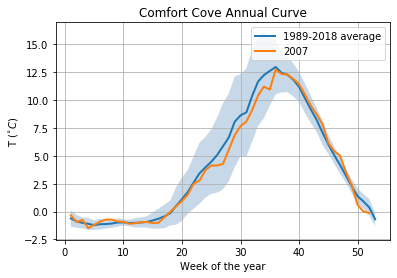

In [34]:
#curve for 1989-2019
ax = weekly_clim.plot(linewidth=2, legend=None)

#curve for 2007
weekly_year.plot(ax=ax, linewidth=2)

#the weekly_clim + and - one std
plt.fill_between(weekly_clim.index, 
                  np.squeeze(weekly_clim.values+weekly_std.values),
                  np.squeeze(weekly_clim.values-weekly_std.values), 
                  facecolor='steelblue', 
                  interpolate=True , 
                  alpha=.3)

plt.ylabel(r'T ($^{\circ}C$)')
plt.xlabel('Week of the year')
plt.title('Comfort Cove Annual Curve')
plt.grid()
plt.legend(['1989-2018 average', 2007])

plt.show()

We can see that there are some weeks that differ from the average, but in almost every week, the 2007 curve stays within one standard deviation of the mean.

### Daily Time Series

In this plot, we have the daily average for a specific month and year. The code is hardcoded to look at June 2005. It is useful for seeing the general trend of the month and for finding any temperature drops or peaks. 

In [35]:
#only looking at 2005
df_series = df_all[df_all.index.year == 2005]
#only looking at June of 2005
df_day = df_series[df_series.index.month == 6]

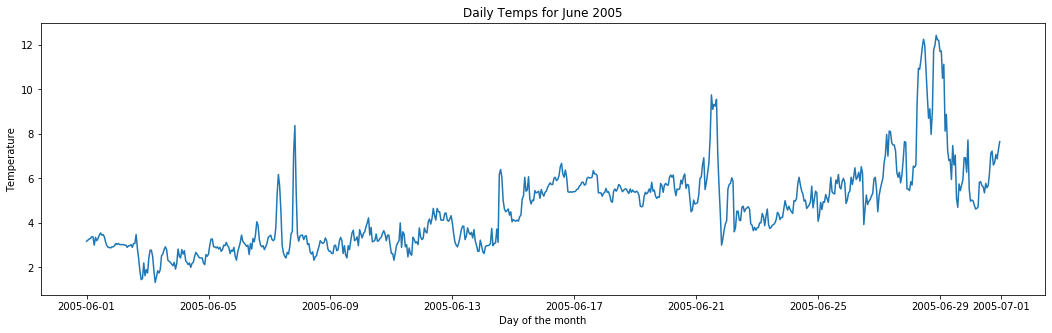

In [36]:
fig, ax = plt.subplots()
plt.plot(df_day.index, df_day['temperature'])

plt.xlabel("Day of the month")
plt.ylabel("Temperature")

plt.title('Daily Temps for June 2005')
fig = ax.get_figure()
fig.set_size_inches(w=18,h=5)

plt.show()

## Climatology

A climatology plot shows the average temperature over a long period of time. This specific plot shows the climatology from 1989-2019 in relation to the time series for 2007.  

In [37]:
#preserves df_all
df2 = copy.deepcopy(df_all)

In [38]:
#creates a new column DOY
df2['doy'] = df2.index.dayofyear 
#groups data on this new column and averages
daily_clim = df2.groupby('doy').mean() 
#finds std
daily_std = df2.groupby('doy').std()

In [39]:
#change here to look at different years
df_year = df2[df2.index.year == 2007] 
daily_year = df_year.groupby('doy').mean()

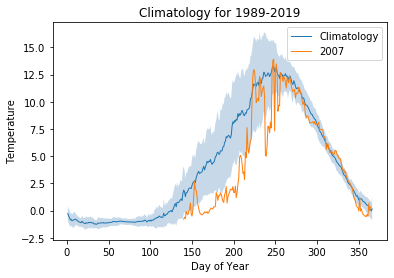

In [40]:
ax = daily_clim.plot(linewidth=1, legend=None)
daily_year.plot(ax=ax, linewidth=1)
plt.fill_between(daily_clim.index,
              np.squeeze(daily_clim.values+daily_std.values),
              np.squeeze(daily_clim.values-daily_std.values),
              facecolor='steelblue',
              interpolate=True ,
              alpha=.3)
plt.title('Climatology for 1989-2019')
plt.xlabel('Day of Year')
plt.ylabel("Temperature")
ax.legend(['Climatology', 2007])

The blue curve in this plot is the average temperature for each day of the year for the years 1989 through 2018, and the upper and lower bounds of the shadow represent one standard deviation away from the mean. The orange curve is the daily temperature for the inputted year, in this case, 2007. 

This plot helps shows us where the 2007 temperatures drop below the climatology curve, and can be used to find upwells.

## Upwells

An upwell is classified as a period of cooling that occurs when surface winds blow across the surface of water, and cause the cold, deep water to rise up to the surface. 

To detect upwells, we first need to find the rolled mean and rolled standard deviation of the temperatures for a specific year. Using the rolled mean and standard deviation, we calculate the upper and lower bounds of the yearly curve. This will be easier to visualize with the plot shown below. 

Once we plot the rolled mean curve, we can plot the curve representing the daily temperature for the year.

In [41]:
#preserves df_all
dfU = copy.deepcopy(df_all)

In [42]:
dfU['doy'] = dfU.index.dayofyear

In [43]:
#looking specifically at 2007
df_year = dfU[dfU.index.year == 2007] 
daily_year = df_year.groupby('doy').mean()

In [44]:
#smooths daily_year curve
rolledMean = daily_year.rolling(30, center = True).mean()
rolledStd = daily_year.rolling(30, center = True).std()

In [45]:
#half of one std away from rolled mean 
lowerBound = rolledMean.values - (rolledStd.values)*0.5
upperBound = rolledMean.values + (rolledStd.values)*0.5

In [46]:
upwellDates = copy.deepcopy(daily_year)

In our code, we classify an upwell as having occured when the daily temperature is less than the lower bound of the rolled mean, where the lowerbound = (mean - std*0.5). 

To show the upwells, we make a copy of the dataframe upwellDates, and then set any value that isn't below the lower bound to NA. When we plot this, only the dates where the temperature is below the lower bound will be highlighted. 

In [47]:
for i in range(len(upwellDates)):
    if((upwellDates.values[i] >= lowerBound[i]) | (np.isnan(lowerBound[i]))):
        upwellDates.values[i] = np.nan

In [48]:
upwellDates[27:34]

,temperature
doy,
167,-0.187500
168,-0.083333
169,-0.246875
170,-0.175000
171,NaN
172,NaN
173,NaN


Above is a section of the dataframe 'upwellDates'. The days 171-173 have a temperature of NaN because they fall within the upper and lower bound of 'rolledMean'. Days 167-170 have a temperature because they fall below the lower bound, and are therfore classfied as an upwell. When we plot 'upwellDates', the upwells are highlighted in green.

Text(0, 0.5, 'Temperature')

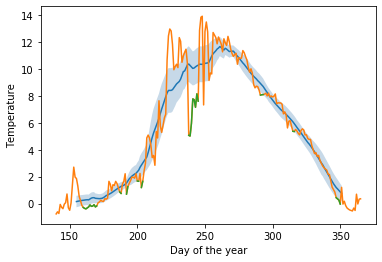

In [49]:
#plots rolled mean of daily_year (blue)
plt.plot(rolledMean)

#plots std of rolled mean of daily year
plt.fill_between(rolledMean.index, np.squeeze(upperBound),
              np.squeeze(lowerBound),facecolor='steelblue',
              interpolate=True, alpha=.3) 

#orange
plt.plot(daily_year)

#green
plt.plot(upwellDates)


plt.xlabel('Day of the year')
plt.ylabel("Temperature")

The blue curve is the rolled mean with upper and lower bounds, the orange curve is the daily temperature, and the green highlights are upwells. 

We can then use the dataframe 'upwellDates' to create a new dataframe that gives us the start date, end date, and duration of each upwell. 

Since we want the absolute date instead of the day of the year, we reset the index and apply a method that finds the absolute date, before making the date the index again and dropping the old 'doy' column. 

In [50]:
upwellDates = upwellDates.reset_index()

In [51]:
#changes 'doy' to an absolute date 
upwellDates.index = pd.DatetimeIndex(upwellDates['doy'].apply(lambda x: date(2007, 1, 1) 
                                                              + relativedelta(days=int(x)-1)))

In [52]:
upwellDates = upwellDates.drop(columns=['doy'])

To find the start and end dates, we just identify the chunk of dates where the temperature is not NaN. 

In [53]:
start = []
end = []
duration = []
count = 0 #used for finding duration
i = 0

In [54]:
#for length of upwellDates
while i < len(upwellDates):
    #if it is not Nan, ie, if temp is below lower bound
    if not np.isnan(upwellDates.values[i][0]): 
        start.append(upwellDates.index.values[i])
    
        while(not np.isnan(upwellDates.values[i][0])):
            i += 1
            count += 1
        
        end.append(upwellDates.index.values[i-1])
        duration.append(count)
        count = 0
    i += 1

In [55]:
data = {'startDate': start, 'endDate': end, 'duration': duration}
upwells = pd.DataFrame(data, columns = ['startDate', 'endDate', 'duration'])

In [56]:
upwells

,startDate,endDate,duration
0,2007-06-09,2007-06-19,11
1,2007-07-06,2007-07-07,2
2,2007-07-11,2007-07-12,2
3,2007-07-19,2007-07-20,2
4,2007-07-22,2007-07-23,2
5,2007-08-01,2007-08-01,1
6,2007-08-26,2007-09-02,8
7,2007-09-06,2007-09-06,1
8,2007-09-10,2007-09-10,1
9,2007-09-12,2007-09-12,1


Now, we have a dataframe with each upwell from 2007, at the Comfort Cove site. 

In the future, we can use these upwell dataframes to learn more about things such as the number of upwells anually, the average duration of upwells, and the difference between upwells for different sites. 